### Industrial Meter Reader [Study Case]
Reference: https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/203-meter-reader/203-meter-reader.ipynb

<img src="meter-reader-flow.png" alt="Meter reader workflow" />

In [2]:
!pip install openvino

                                              0.0/27.2 MB ? eta -:--:--
                                              0.0/27.2 MB ? eta -:--:--
                                             0.1/27.2 MB 812.7 kB/s eta 0:00:34
                                              0.5/27.2 MB 4.5 MB/s eta 0:00:06
     -                                        1.4/27.2 MB 8.5 MB/s eta 0:00:04
     ---                                      2.7/27.2 MB 13.3 MB/s eta 0:00:02
     -------                                  5.0/27.2 MB 20.0 MB/s eta 0:00:02
     -------                                  5.2/27.2 MB 20.9 MB/s eta 0:00:02
     -------                                  5.2/27.2 MB 20.9 MB/s eta 0:00:02
     -------                                  5.2/27.2 MB 20.9 MB/s eta 0:00:02
     -------                                  5.2/27.2 MB 20.9 MB/s eta 0:00:02
     -------                                  5.2/27.2 MB 20.9 MB/s eta 0:00:02
     ---------                                6.3/27.2 MB 

In [4]:
!pip install notebook-utils

In [18]:
import os
import sys
from pathlib import Path
import numpy as np
import math
import cv2
import tarfile
import matplotlib.pyplot as plt
import openvino.runtime as ov
import urllib.request

# sys.path.append("../utils")
# from notebook_utils import download_file, segmentation_map_to_image

In [24]:
## Prepare the Model and Test Image
MODEL_DIR = "model"
DATA_DIR = "data"
### model detection and segmentation download
DET_MODEL_LINK = "https://bj.bcebos.com/paddlex/examples2/meter_reader/meter_det_model.tar.gz"
SEG_MODEL_LINK = "https://bj.bcebos.com/paddlex/examples2/meter_reader/meter_seg_model.tar.gz"
IMG_LINK = "https://user-images.githubusercontent.com/91237924/170696219-f68699c6-1e82-46bf-aaed-8e2fc3fa5f7b.jpg"
IMG_FILE_NAME = IMG_LINK.split("/")[-1]
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

In [19]:
urllib.request.urlretrieve(DET_MODEL_LINK, Path(f"{MODEL_DIR}/meter_det_model.tar.gz"))

(WindowsPath('model/meter_det_model.tar.gz'),
 <http.client.HTTPMessage at 0x213bddc3d60>)

In [20]:
urllib.request.urlretrieve(SEG_MODEL_LINK, Path(f"{MODEL_DIR}/meter_seg_model.tar.gz"))

(WindowsPath('model/meter_seg_model.tar.gz'),
 <http.client.HTTPMessage at 0x213be464940>)

In [28]:
### extract meter detection model from .tar.gz
file = tarfile.open(f"model/meter_det_model.tar.gz")
res = file.extractall("model")
if not res:
    print(f"Detection Model Extracted to \"./{MODEL_DIR}\".")
else:
    print("Error Extracting the Detection model. Please check the network.")

Detection Model Extracted to "./model".


In [29]:
### extract segmentation model from .tar.gz
file = tarfile.open(f"model/meter_seg_model.tar.gz")
res = file.extractall("model")
if not res:
    print(f"Segmentation Model Extracted to \"./{MODEL_DIR}\".")
else:
    print("Error Extracting the Segmentation model. Please check the network.")

Segmentation Model Extracted to "./model".


In [30]:
### Configuration to detect meter and extract from image
METER_SHAPE = [512, 512] 
CIRCLE_CENTER = [256, 256] 
CIRCLE_RADIUS = 250
PI = math.pi
RECTANGLE_HEIGHT = 120
RECTANGLE_WIDTH = 1570
TYPE_THRESHOLD = 40
COLORMAP = np.array([[28, 28, 28], [238, 44, 44], [250, 250, 250]])

# There are 2 types of meters in test image datasets
METER_CONFIG = [{
    'scale_interval_value': 25.0 / 50.0,
    'range': 25.0,
    'unit': "(MPa)"
}, {
    'scale_interval_value': 1.6 / 32.0,
    'range': 1.6,
    'unit': "(MPa)"
}]

SEG_LABEL = {'background': 0, 'pointer': 1, 'scale': 2}

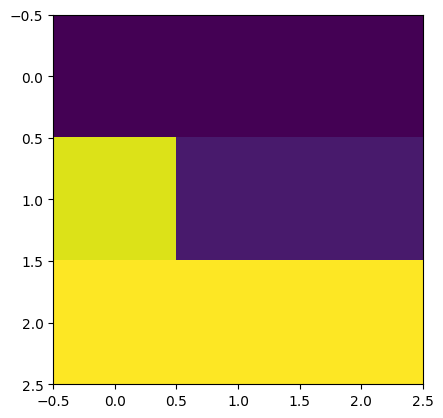

In [31]:
plt.imshow(COLORMAP)

In [32]:
### Load the Models
# Initialize OpenVINO Runtime
ie_core = ov.Core()


class Model:
    """
    This class represents a OpenVINO model object.

    """
    def __init__(self, model_path, new_shape):
        """
        Initialize the model object
        
        Param: 
            model_path (string): path of inference model
            new_shape (dict): new shape of model input

        """
        self.model = ie_core.read_model(model=model_path)
        self.model.reshape(new_shape)
        self.compiled_model = ie_core.compile_model(model=self.model, device_name="CPU")
        self.output_layer = self.compiled_model.output(0)

    def predict(self, input_image):
        """
        Run inference
        
        Param: 
            input_image (np.array): input data
            
        Retuns:
            result (np.array)): model output data
        """
        result = self.compiled_model(input_image)[self.output_layer]
        return result

In [33]:
## Data Process

### Preprocess image to detect the meter
def det_preprocess(input_image, target_size):
    """
    Preprocessing the input data for detection task

    Param: 
        input_image (np.array): input data
        size (int): the image size required by model input layer
    Retuns:
        img.astype (np.array): preprocessed image
    
    """
    img = cv2.resize(input_image, (target_size, target_size))
    img = np.transpose(img, [2, 0, 1]) / 255
    img = np.expand_dims(img, 0)
    img_mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    img_std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
    img -= img_mean
    img /= img_std
    return img.astype(np.float32)

### BBoxes image to detect the meter
def filter_bboxes(det_results, score_threshold):
    """
    Filter out the detection results with low confidence

    Param：
        det_results (list[dict]): detection results
        score_threshold (float)： confidence threshold

    Retuns：
        filtered_results (list[dict]): filter detection results
    
    """
    filtered_results = []
    for i in range(len(det_results)):
        if det_results[i, 1] > score_threshold:
            filtered_results.append(det_results[i])
    return filtered_results

### Crop area of interest from bboxes that detect the meter
def roi_crop(image, results, scale_x, scale_y):
    """
    Crop the area of detected meter of original image

    Param：
        img (np.array)：original image。
        det_results (list[dict]): detection results
        scale_x (float): the scale value in x axis
        scale_y (float): the scale value in y axis

    Retuns：
        roi_imgs (list[np.array]): the list of meter images
        loc (list[int]): the list of meter locations
    
    """
    roi_imgs = []
    loc = []
    for result in results:
        bbox = result[2:]
        xmin, ymin, xmax, ymax = [int(bbox[0] * scale_x), int(bbox[1] * scale_y), int(bbox[2] * scale_x), int(bbox[3] * scale_y)]
        sub_img = image[ymin:(ymax + 1), xmin:(xmax + 1), :]
        roi_imgs.append(sub_img)
        loc.append([xmin, ymin, xmax, ymax])
    return roi_imgs, loc

### Preprocess image from area of interest to segment meter in next step
def roi_process(input_images, target_size, interp=cv2.INTER_LINEAR):
    """
    Prepare the roi image of detection results data
    Preprocessing the input data for segmentation task

    Param：
        input_images (list[np.array])：the list of meter images
        target_size (list|tuple)： height and width of resized image， e.g [heigh,width]
        interp (int)：the interp method for image reszing

    Retuns：
        img_list (list[np.array])：the list of processed images
        resize_img (list[np.array]): for visualization
    
    """
    img_list = list()
    resize_list = list()
    for img in input_images:
        img_shape = img.shape
        scale_x = float(target_size[1]) / float(img_shape[1])
        scale_y = float(target_size[0]) / float(img_shape[0])
        resize_img = cv2.resize(img, None, None, fx=scale_x, fy=scale_y, interpolation=interp)
        resize_list.append(resize_img)
        resize_img = resize_img.transpose(2, 0, 1) / 255
        img_mean = np.array([0.5, 0.5, 0.5]).reshape((3, 1, 1))
        img_std = np.array([0.5, 0.5, 0.5]).reshape((3, 1, 1))
        resize_img -= img_mean
        resize_img /= img_std
        img_list.append(resize_img)
    return img_list, resize_list

### Erode to the segment meter result
def erode(seg_results, erode_kernel):
    """
    Erode the segmentation result to get the more clear instance of pointer and scale

    Param：
        seg_results (list[dict])：segmentation results
        erode_kernel (int): size of erode_kernel

    Return：
        eroded_results (list[dict])： the lab map of eroded_results
        
    """
    kernel = np.ones((erode_kernel, erode_kernel), np.uint8)
    eroded_results = seg_results
    for i in range(len(seg_results)):
        eroded_results[i] = cv2.erode(seg_results[i].astype(np.uint8), kernel)
    return eroded_results

### Convert circle shape into retangle shape to read meter
def circle_to_rectangle(seg_results):
    """
    Switch the shape of label_map from circle to rectangle

    Param：
        seg_results (list[dict])：segmentation results

    Return：
        rectangle_meters (list[np.array])：the rectangle of label map

    """
    rectangle_meters = list()
    for i, seg_result in enumerate(seg_results):
        label_map = seg_result

        # The size of rectangle_meter is determined by RECTANGLE_HEIGHT and RECTANGLE_WIDTH
        rectangle_meter = np.zeros((RECTANGLE_HEIGHT, RECTANGLE_WIDTH), dtype=np.uint8)
        for row in range(RECTANGLE_HEIGHT):
            for col in range(RECTANGLE_WIDTH):
                theta = PI * 2 * (col + 1) / RECTANGLE_WIDTH
                
                # The radius of meter circle will be mapped to the height of rectangle image
                rho = CIRCLE_RADIUS - row - 1
                y = int(CIRCLE_CENTER[0] + rho * math.cos(theta) + 0.5)
                x = int(CIRCLE_CENTER[1] - rho * math.sin(theta) + 0.5)
                rectangle_meter[row, col] = label_map[y, x]
        rectangle_meters.append(rectangle_meter)
    return rectangle_meters

### Read line scale and pointer on images
def rectangle_to_line(rectangle_meters):
    """
    Switch the dimension of rectangle label map from 2D to 1D

    Param：
        rectangle_meters (list[np.array])：2D rectangle OF label_map。

    Return：
        line_scales (list[np.array])： the list of scales value
        line_pointers (list[np.array])：the list of pointers value

    """
    line_scales = list()
    line_pointers = list()
    for rectangle_meter in rectangle_meters:
        height, width = rectangle_meter.shape[0:2]
        line_scale = np.zeros((width), dtype=np.uint8)
        line_pointer = np.zeros((width), dtype=np.uint8)
        for col in range(width):
            for row in range(height):
                if rectangle_meter[row, col] == SEG_LABEL['pointer']:
                    line_pointer[col] += 1
                elif rectangle_meter[row, col] == SEG_LABEL['scale']:
                    line_scale[col] += 1
        line_scales.append(line_scale)
        line_pointers.append(line_pointer)
    return line_scales, line_pointers

def mean_binarization(data_list):
    """
    Binarize the data

    Param：
        data_list (list[np.array])：input data

    Return：
        binaried_data_list (list[np.array])：output data。

    """
    batch_size = len(data_list)
    binaried_data_list = data_list
    for i in range(batch_size):
        mean_data = np.mean(data_list[i])
        width = data_list[i].shape[0]
        for col in range(width):
            if data_list[i][col] < mean_data:
                binaried_data_list[i][col] = 0
            else:
                binaried_data_list[i][col] = 1
    return binaried_data_list

### 
def locate_scale(line_scales):
    """
    Find location of center of each scale

    Param：
        line_scales (list[np.array])：the list of binaried scales value

    Return：
        scale_locations (list[list])：location of each scale

    """
    batch_size = len(line_scales)
    scale_locations = list()
    for i in range(batch_size):
        line_scale = line_scales[i]
        width = line_scale.shape[0]
        find_start = False
        one_scale_start = 0
        one_scale_end = 0
        locations = list()
        for j in range(width - 1):
            if line_scale[j] > 0 and line_scale[j + 1] > 0:
                if not find_start:
                    one_scale_start = j
                    find_start = True
            if find_start:
                if line_scale[j] == 0 and line_scale[j + 1] == 0:
                    one_scale_end = j - 1
                    one_scale_location = (one_scale_start + one_scale_end) / 2
                    locations.append(one_scale_location)
                    one_scale_start = 0
                    one_scale_end = 0
                    find_start = False
        scale_locations.append(locations)
    return scale_locations

def locate_pointer(line_pointers):
    """
    Find location of center of pointer

    Param：
        line_scales (list[np.array])：the list of binaried pointer value

    Return：
        scale_locations (list[list])：location of pointer

    """
    batch_size = len(line_pointers)
    pointer_locations = list()
    for i in range(batch_size):
        line_pointer = line_pointers[i]
        find_start = False
        pointer_start = 0
        pointer_end = 0
        location = 0
        width = line_pointer.shape[0]
        for j in range(width - 1):
            if line_pointer[j] > 0 and line_pointer[j + 1] > 0:
                if not find_start:
                    pointer_start = j
                    find_start = True
            if find_start:
                if line_pointer[j] == 0 and line_pointer[j + 1] == 0 :
                    pointer_end = j - 1
                    location = (pointer_start + pointer_end) / 2
                    find_start = False
                    break
        pointer_locations.append(location)
    return pointer_locations


def get_relative_location(scale_locations, pointer_locations):
    """
    Match location of pointer and scales

    Param：
        scale_locations (list[list])：location of each scale
        pointer_locations (list[list])：location of pointer

    Return：
        pointed_scales (list[dict])： a list of dict with:
                                     'num_scales': total number of scales
                                     'pointed_scale': predicted number of scales
            
    """
    pointed_scales = list()
    for scale_location, pointer_location in zip(scale_locations,
                                                pointer_locations):
        num_scales = len(scale_location)
        pointed_scale = -1
        if num_scales > 0:
            for i in range(num_scales - 1):
                if scale_location[i] <= pointer_location < scale_location[i + 1]:
                    pointed_scale = i + (pointer_location - scale_location[i]) / (scale_location[i + 1] - scale_location[i] + 1e-05) + 1
        result = {'num_scales': num_scales, 'pointed_scale': pointed_scale}
        pointed_scales.append(result)
    return pointed_scales


def calculate_reading(pointed_scales):
    """
    Calculate the value of meter according to the type of meter

    Param：
        pointed_scales (list[list])：predicted number of scales

    Return：
        readings (list[float])： the list of values read from meter
            
    """
    readings = list()
    batch_size = len(pointed_scales)
    for i in range(batch_size):
        pointed_scale = pointed_scales[i]
        # find the type of meter according the total number of scales
        if pointed_scale['num_scales'] > TYPE_THRESHOLD:
            reading = pointed_scale['pointed_scale'] * METER_CONFIG[0]['scale_interval_value']
        else:
            reading = pointed_scale['pointed_scale'] * METER_CONFIG[1]['scale_interval_value']
        readings.append(reading)
    return readings

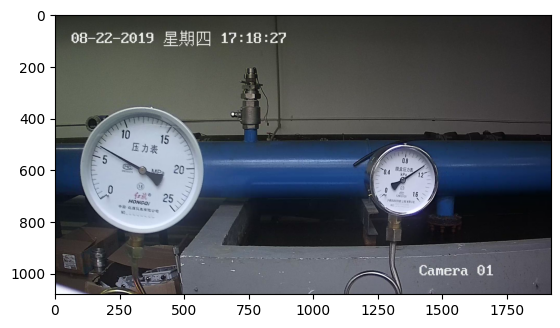

In [34]:
## Main Function
### Initialize the model and parameters.
img_file = "data/170696219-f68699c6-1e82-46bf-aaed-8e2fc3fa5f7b.jpg"
det_model_path = f"{MODEL_DIR}/meter_det_model/model.pdmodel"
det_model_shape = {'image': [1, 3, 608, 608], 'im_shape': [1, 2], 'scale_factor': [1, 2]}
seg_model_path = f"{MODEL_DIR}/meter_seg_model/model.pdmodel"
seg_model_shape = {'image': [ov.Dimension(1, 2), 3, 512, 512]}

erode_kernel = 4
score_threshold = 0.5
seg_batch_size = 2
input_shape = 608

# Intialize the model objects
detector = Model(det_model_path, det_model_shape)
segmenter = Model(seg_model_path, seg_model_shape)

# Visulize a original input photo
image = cv2.imread(img_file)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image)


The detection result image has been saved as "detection_results.jpg" in data


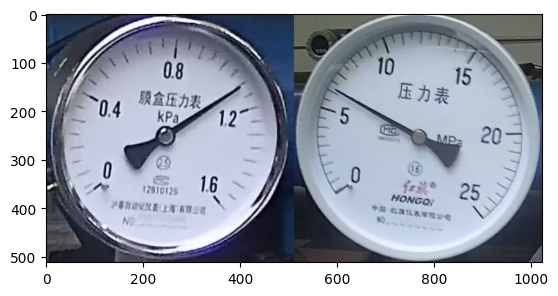

In [35]:
### Run meter detection model
# Prepare the input data for meter detection model
im_shape = np.array([[input_shape, input_shape]]).astype('float32')
scale_factor = np.array([[1, 2]]).astype('float32')
input_image = det_preprocess(image, input_shape)
inputs_dict = {'image': input_image, "im_shape": im_shape, "scale_factor": scale_factor}

# Run meter detection model
det_results = detector.predict(inputs_dict)

# Filter out the bounding box with low confidence
filtered_results = filter_bboxes(det_results, score_threshold)

# Prepare the input data for meter segmentation model
scale_x = image.shape[1] / input_shape * 2
scale_y = image.shape[0] / input_shape

# Create the individual picture for each detected meter
roi_imgs, loc = roi_crop(image, filtered_results, scale_x, scale_y)
roi_imgs, resize_imgs = roi_process(roi_imgs, METER_SHAPE)

# Create the pictures of detection results
roi_stack = np.hstack(resize_imgs)

if cv2.imwrite(f"{DATA_DIR}/detection_results.jpg", roi_stack):
    print("The detection result image has been saved as \"detection_results.jpg\" in data")
    plt.imshow(cv2.cvtColor(roi_stack, cv2.COLOR_BGR2RGB))

In [37]:
def segmentation_map_to_image(
    result: np.ndarray, colormap: np.ndarray, remove_holes: bool = False
) -> np.ndarray:
    """
    Convert network result of floating point numbers to an RGB image with
    integer values from 0-255 by applying a colormap.

    :param result: A single network result after converting to pixel values in H,W or 1,H,W shape.
    :param colormap: A numpy array of shape (num_classes, 3) with an RGB value per class.
    :param remove_holes: If True, remove holes in the segmentation result.
    :return: An RGB image where each pixel is an int8 value according to colormap.
    """
    if len(result.shape) != 2 and result.shape[0] != 1:
        raise ValueError(
            f"Expected result with shape (H,W) or (1,H,W), got result with shape {result.shape}"
        )

    if len(np.unique(result)) > colormap.shape[0]:
        raise ValueError(
            f"Expected max {colormap[0]} classes in result, got {len(np.unique(result))} "
            "different output values. Please make sure to convert the network output to "
            "pixel values before calling this function."
        )
    elif result.shape[0] == 1:
        result = result.squeeze(0)

    result = result.astype(np.uint8)

    contour_mode = cv2.RETR_EXTERNAL if remove_holes else cv2.RETR_TREE
    mask = np.zeros((result.shape[0], result.shape[1], 3), dtype=np.uint8)
    for label_index, color in enumerate(colormap):
        label_index_map = result == label_index
        label_index_map = label_index_map.astype(np.uint8) * 255
        contours, hierarchies = cv2.findContours(
            label_index_map, contour_mode, cv2.CHAIN_APPROX_SIMPLE
        )
        cv2.drawContours(
            mask,
            contours,
            contourIdx=-1,
            color=color.tolist(),
            thickness=cv2.FILLED,
        )

    return mask

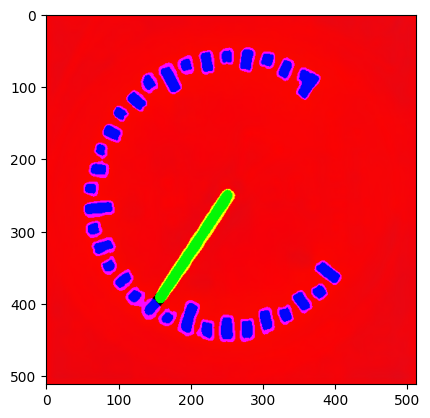

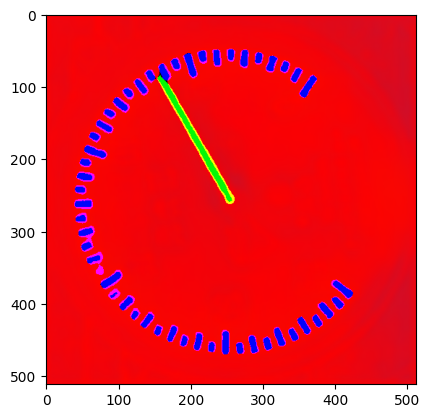

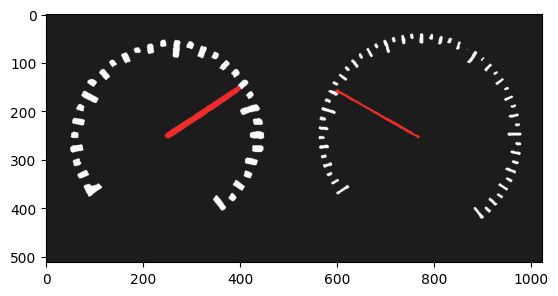

In [90]:
### Run meter segmentation model
seg_results = list()
mask_list = list()
num_imgs = len(roi_imgs)

# Run meter segmentation model on all detected meters
for i in range(0, num_imgs, seg_batch_size):
    batch = roi_imgs[i : min(num_imgs, i + seg_batch_size)]
    seg_result = segmenter.predict({"image": np.array(batch)})
    plt.imshow(np.array(seg_result[0]).transpose(2, 1, 0).astype(np.uint8)*255)
    plt.show()
    plt.imshow(np.array(seg_result[1]).transpose(2, 1, 0).astype(np.uint8)*255)
    plt.show()
    seg_results.extend(seg_result)

results = []
for i in range(len(seg_results)):
    results.append(np.argmax(seg_results[i], axis=0)) 
seg_results = erode(results, erode_kernel)

# # Create the pictures of segmentation results
for i in range(len(seg_results)):
    mask_list.append(segmentation_map_to_image(seg_results[i], COLORMAP))
mask_stack = np.hstack(mask_list)

# # if cv2.imwrite(f"{DATA_DIR}/segmentation_results.jpg", cv2.cvtColor(mask_stack, cv2.COLOR_RGB2BGR)):
# #     print("The segmentation result image has been saved as \"segmentation_results.jpg\" in data")
plt.imshow(mask_stack)

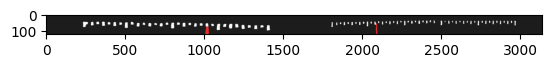

In [69]:
### Postprocess the models result and calculate the final readings
# Find the pointer location in scale map and calculate the meters reading 
rectangle_meters = circle_to_rectangle(seg_results)
line_scales, line_pointers = rectangle_to_line(rectangle_meters)
binaried_scales = mean_binarization(line_scales)
binaried_pointers = mean_binarization(line_pointers)
scale_locations = locate_scale(binaried_scales)
pointer_locations = locate_pointer(binaried_pointers)
pointed_scales = get_relative_location(scale_locations, pointer_locations)
meter_readings = calculate_reading(pointed_scales)

rectangle_list = list()
# Plot the rectangle meters
for i in range(len(rectangle_meters)):
    rectangle_list.append(segmentation_map_to_image(rectangle_meters[i], COLORMAP))
rectangle_meters_stack = np.hstack(rectangle_list)

plt.imshow(rectangle_meters_stack)

The rectangle_meters result image has been saved as "rectangle_meters.jpg" in data


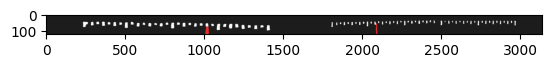

In [78]:
if cv2.imwrite(f"{DATA_DIR}/rectangle_meters.jpg", cv2.cvtColor(rectangle_meters_stack, cv2.COLOR_RGB2BGR)):
    print("The rectangle_meters result image has been saved as \"rectangle_meters.jpg\" in data")
    plt.imshow(rectangle_meters_stack)

Meter 1: 1.100
Meter 2: 6.185


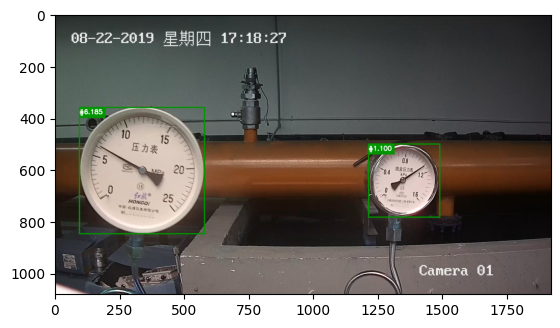

In [79]:
# Create a final result photo with reading
for i in range(len(meter_readings)):
    print("Meter {}: {:.3f}".format(i + 1, meter_readings[i]))
    
result_image = image.copy()
for i in range(len(loc)):
    cv2.rectangle(result_image,(loc[i][0], loc[i][1]), (loc[i][2], loc[i][3]), (0, 150, 0), 3)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.rectangle(result_image, (loc[i][0], loc[i][1]), (loc[i][0] + 100, loc[i][1] + 40), (0, 150, 0), -1)
    cv2.putText(result_image, "#{:.3f}".format(meter_readings[i]), (loc[i][0],loc[i][1] + 25), font, 0.8, (255, 255, 255), 2, cv2.LINE_AA)

plt.imshow(result_image)

The reading results image has been saved as "reading_results.jpg" in data


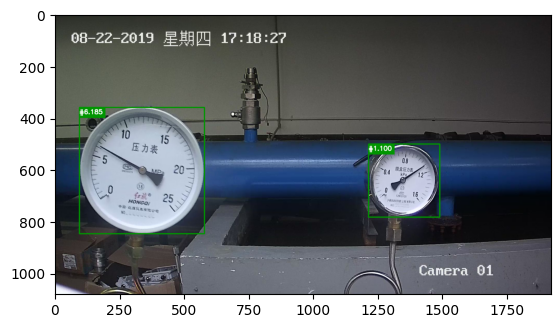

In [80]:
if cv2.imwrite(f"{DATA_DIR}/reading_results.jpg", result_image):
    print("The reading results image has been saved as \"reading_results.jpg\" in data")
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))